### Libraries Needed

In [66]:
# Libraries needed
import pandas as pd 
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA  #using this for PCA
from mpl_toolkits.mplot3d import Axes3D #using this for 3d scatter
from matplotlib.colors import ListedColormap #using this for 3d scatter

import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline 

### The Data 

In [82]:
# Load the Iris dataset

iris = load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

colors = iris_df['target'].replace([0,1,2],['r', 'g', 'b'])
iris_df['target'] = iris_df['target'].replace([0,1,2],['setosa', 'versicolor', 'virginica'])
iris_df.head()

# Initial Summary with Pandas Profiler

prof = ProfileReport(iris_df, title = "Iris Dataset")
prof.to_notebook_iframe()


Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
iris_k = iris_df.drop(columns='target')
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


### Elbow Plot and K-Means Test

[Text(0.5, 1.0, 'Eblow Plot of K-Means for Iris Data')]

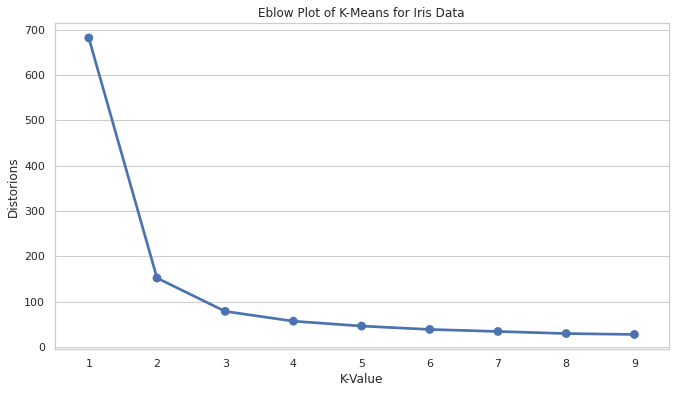

In [61]:
# Running K-means and creating Elbow Plot

distortions = list()
Ks = range(1,10)   # Creates Ks from 1 to 10 to test representing number of clusters

for k in Ks:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(iris_df.drop(columns='target'))
    distortions.append(kmeanModel.inertia_)  # Records distortions for each value of K

k_data= pd.DataFrame({'K-Value':Ks,         #Creating df of ks vs distorions
                      'Distorions':distortions
                     })

fig_dims = (11, 6)
fig, ax = plt.subplots(figsize=fig_dims)

sns.set_theme(style="whitegrid")
sns.pointplot(data=k_data,x='K-Value',y='Distorions',
              markers=["o"]).set(title='Eblow Plot of K-Means for Iris Data')

To determine the optimal number of clusters, we have to select the value of k at the “elbow”. This is the point after which the distortions start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 3.

### PCA

In [38]:
# Preparing data for PCA
# PCA is effected by scale so we will need to scale the variables beforehand

X = iris_df.drop(columns='target').values
Y = iris_df.loc[:,['target']].values
X = StandardScaler().fit_transform(X) # Standarizes the 4 numeric variables

pca_3 = PCA(n_components=3)  # Creating a PCA with 3 components rather than 4
pca_2 = PCA(n_components=2)  # Creating a PCA with 2 components rather than 4

In [67]:
# Converting the PCA data to Data Frames with target column

principalComponents_3 = pca_3.fit_transform(X) # Converts to array
principalComponents_2 = pca_2.fit_transform(X)
pca_3_df = pd.DataFrame(data = principalComponents_3 # Converts to DF
             , columns = ['PC1', 'PC2','PC3'])
pca_2_df = pd.DataFrame(data = principalComponents_2
             , columns = ['PC1', 'PC2'])

pca_3_df['target'] = iris_df.loc[:,['target']]   # Re-adding the target column
pca_2_df['target'] = iris_df.loc[:,['target']]

[Text(0.5, 1.0, '2 Component PCA of Iris Data')]

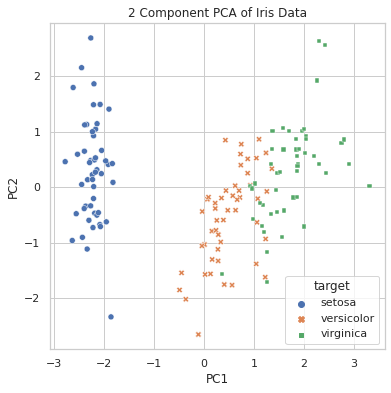

In [65]:
# Scatterplot of the iris data reduced to 2 Principal Components

fig_dims = (6, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(data=pca_2_df, x='PC1',y='PC2',hue='target',
                style='target').set(title='2 Component PCA of Iris Data')

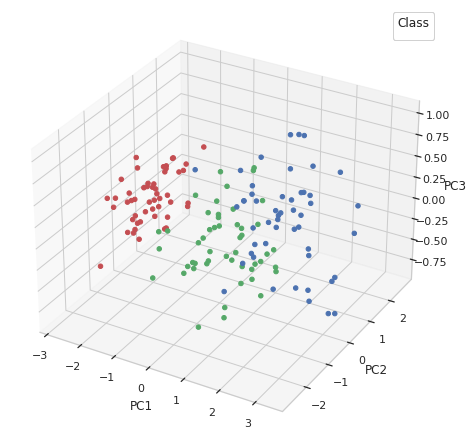

In [92]:
# Scatterplot of the iris data reduced to 3 Principal Components

# Creating 3D axes
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex()) # Colormap magic

scatter_3d = ax.scatter(pca_3_df['PC1'], pca_3_df['PC2'], pca_3_df['PC3'], c=colors,
                         marker='o', cmap=cmap, alpha=1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
legend = ax.legend(*scatter_3d.legend_elements(), title='Class')
ax.add_artist(legend)
plt.show()